In [73]:
#interactive widgets in vs code
# %matplotlib widget

#dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import bagpy
from bagpy import bagreader
plt.close('all')

In [74]:
# Read rosbag data

#bag_filename = "data/_202211301120.51.bag"
#bag_filename = "data/_202211301118.14.bag"
#bag_filename = "data/_202211301115.18.bag"

bag_filename = "data/run1.bag"
bag = bagreader(bag_filename)
#bag.topic_table

[INFO]  Data folder data/run1 already exists. Not creating.


In [75]:
# extract acceleration data, and convert to pandas dataframe
accel_df = pd.read_csv(bag.message_by_topic('/imu/acceleration'))
accel_df.head(3)

,Time,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,vector.x,vector.y,vector.z
0,1.669803e+09,250,1669803320,423047544,imu_link,-1.434981,0.498791,9.674213
1,1.669803e+09,251,1669803320,428319850,imu_link,-1.426545,0.546572,9.681358
2,1.669803e+09,252,1669803320,432516182,imu_link,-1.436896,0.555246,9.700562


In [76]:
# extract angular velocities, and convert to pandas dataframe
gyro_df = pd.read_csv(bag.message_by_topic('/imu/angular_velocity'))
gyro_df.head(3)

,Time,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,vector.x,vector.y,vector.z
0,1.669803e+09,250,1669803320,423047544,imu_link,0.003190,-0.004760,0.003020
1,1.669803e+09,251,1669803320,428319850,imu_link,-0.001221,-0.005975,-0.000975
2,1.669803e+09,252,1669803320,432516182,imu_link,0.001955,-0.001276,-0.003164


In [78]:
# calculate time difference between measurements
accel_df['time_diff_ns'] = accel_df['header.stamp.secs'].diff(1) + accel_df['header.stamp.nsecs'].diff(1) / 1e9
timesteps = accel_df['time_diff_ns'].to_numpy()     # get array and convert to numpy

# take rolling average of IMU data and store to numpy array, this is to filter noise
averaging_window = 20
vec_accel_raw = accel_df[['vector.x', 'vector.y', 'vector.z']].rolling(averaging_window).mean().to_numpy()
vec_gyro_raw = gyro_df[['vector.x', 'vector.y', 'vector.z']].rolling(averaging_window).mean().to_numpy()

# drop nan values
timesteps = timesteps[averaging_window:]
vec_accel_raw = vec_accel_raw[averaging_window:]
vec_gyro_raw = vec_gyro_raw[averaging_window:]

In [80]:
# do calibrations based on scale and bias values
accel_bias =  np.array([ 0.004432,  0.009620, -0.011343])
accel_scale = np.array([ 0.000081, -0.000767,  0.000080])
gyro_bias =   np.array([-0.003728,  0.000588, -0.001389])
#gyro_scale =  np.array([-1.008336, -1.003484, -1.010797])  #unreasonable values, ignore
gyro_scale =  np.array([0, 0, 0])

accel_bias = -np.mean(vec_accel_raw[:1000], axis=0)

vec_accel = accel_bias + (1 + accel_scale) * vec_accel_raw
vec_gyro = gyro_bias + (1 + gyro_scale) * vec_gyro_raw

#vec_accel[:, 2] -= 9.8 # subtract gravity from z

In [37]:
# bias_begin = -np.mean(vec_accel_raw[:1000], axis=0)
# bias_end = -np.mean(vec_accel_raw[-500:], axis=0)

# print(f"{bias_begin = }")
# print(f"{bias_end =   }")

# a = (bias_end-bias_begin) / len(timesteps)

# bias_over_time = bias_begin + a * timesteps[:, np.newaxis]
# vec_accel = accel_bias + (1 + accel_scale) * vec_accel_raw

In [38]:
# plot the data to get an idea of the values
# plt.figure(figsize=(10, 3))
# plt.plot(vec_accel)
# plt.plot(vec_gyro)
# plt.legend(['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z'])
# plt.show()

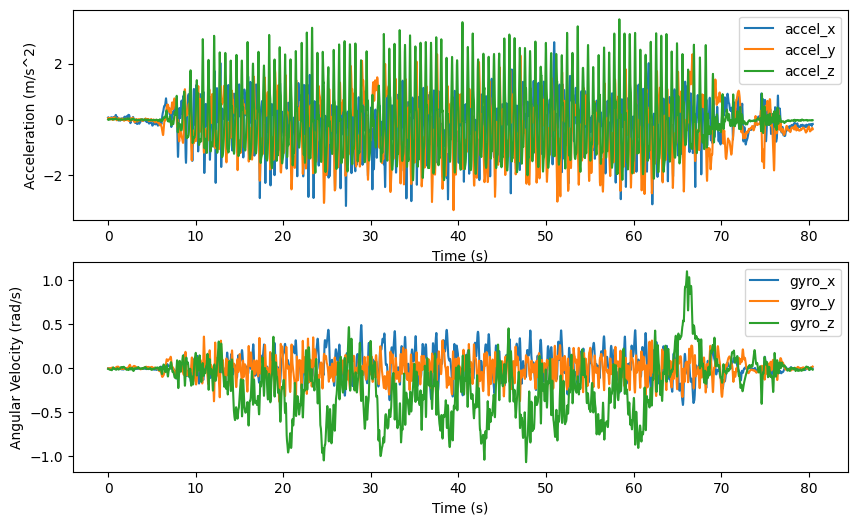

In [81]:
# set figure size and create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

time = np.cumsum(timesteps)  # cumulative sum of time differences to get time values
# plot acceleration data in the top subplot
axs[0].plot(time, vec_accel)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Acceleration (m/s^2)')
axs[0].legend(['accel_x', 'accel_y', 'accel_z'])

# plot angular velocity data in the bottom subplot
axs[1].plot(time, vec_gyro)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Angular Velocity (rad/s)')
axs[1].legend(['gyro_x', 'gyro_y', 'gyro_z'])

plt.show()


In [82]:
# integrate angular velocity to find rotation (multiply with timestep, then cumulative sum)
vec_rotation = np.cumsum(vec_gyro[0:-1, :] * timesteps[0:-1, np.newaxis], axis=0)

# vec_velocity = np.ones_like(vec_velocity)
# vec_velocity[:, 2] = 0

# rotation calculations
vec_accel_rotated = np.zeros_like(vec_rotation)
for nr, rotation_measure in enumerate(vec_rotation):    # loop over vectors
    roll, pitch, yaw = rotation_measure
    rollMatrix = np.matrix([                    # rotation about x
        [1, 0,             0           ],
        [0, np.cos(roll), -np.sin(roll)],
        [0, np.sin(roll),  np.cos(roll)]])
    pitchMatrix = np.matrix([                   # rotation about y
        [ np.cos(pitch), 0, np.sin(pitch)],
        [0,              1,  0           ],
        [-np.sin(pitch), 0, np.cos(pitch)]])
    yawMatrix = np.matrix([                     # rotation about z
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw),  np.cos(yaw), 0],
        [0,            0,           1]])

    R = yawMatrix * pitchMatrix * rollMatrix        # combined rotation matrix
    velocity_rotated = np.matmul(R, vec_accel[nr])     # matrix multiplication with accel vector

    vec_accel_rotated[nr, :] = velocity_rotated        # add to array

In [55]:
# # Attemp calculate the roation array to the first frame, by multipling each the previous rotation matrix with a newely calculated one.
# vec_accel1 = vec_accel[0:-1]
# prevR = [[1,0,0],[0,1,0],[0,0,1]]   # identity matrix as start

# # rotation calculations
# vec_accel_rotated = np.zeros_like(vec_rotation)
# for nr, rotation_measure in enumerate(vec_gyro):    # loop over vectors
#     GyroX, GyroY, GyroZ = rotation_measure
#     rollMatrix = np.matrix([                    # rotation about x
#         [1, 0,             0           ],
#         [0, np.cos(GyroX), -np.sin(GyroX)],
#         [0, np.sin(GyroX),  np.cos(GyroX)]])
#     pitchMatrix = np.matrix([                   # rotation about y
#         [ np.cos(GyroY), 0, np.sin(GyroY)],
#         [0,              1,  0           ],
#         [-np.sin(GyroY), 0, np.cos(GyroY)]])
#     yawMatrix = np.matrix([                     # rotation about z
#         [np.cos(GyroZ), -np.sin(GyroZ), 0],
#         [np.sin(GyroZ),  np.cos(GyroZ), 0],
#         [0,            0,           1]])

#     R = yawMatrix * pitchMatrix * rollMatrix * prevR       # combined rotation matrix
#     accel_rotated = np.matmul(R, vec_accel[nr])     # matrix multiplication with accel vector
#     vec_accel_rotated[nr, :] = accel_rotated        # add to array
#     prevR = R

In [22]:
# # plot the data to get an idea of the values
# plt.figure(figsize=(10, 3))
# plt.plot(vec_accel)
# plt.plot(vec_accel_rotated)
# plt.legend(['vel_x', 'vel_y', 'vel_z', 'vel_x_rotated', 'vel_y_rotated', 'vel_z_rotated'])
# plt.show()

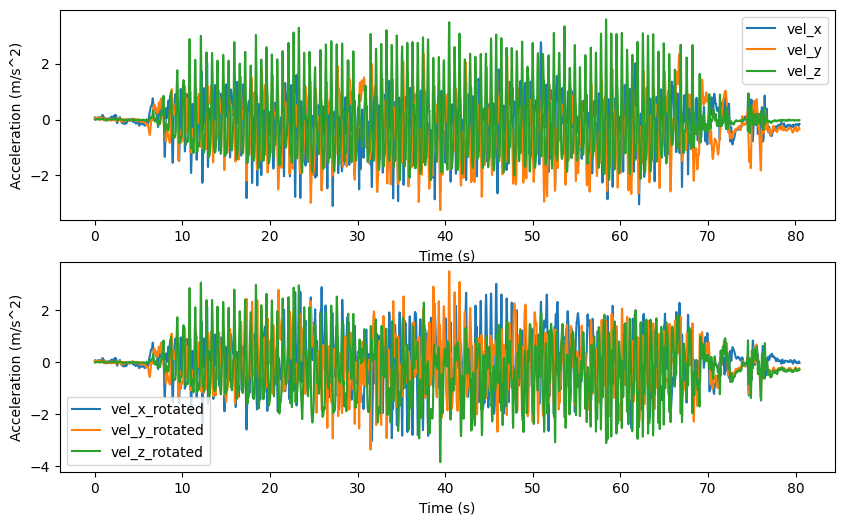

In [83]:
# set figure size and create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 6))
time = np.cumsum(timesteps)  # cumulative sum of time differences to get time values

# plot acceleration data in the top subplot
axs[0].plot(time, vec_accel)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Acceleration (m/s^2)')
axs[0].legend(['vel_x', 'vel_y', 'vel_z'])

# plot the rotated acceleration data in the top subplot
axs[1].plot(time[0:-1], vec_accel_rotated)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Acceleration (m/s^2)')
axs[1].legend(['vel_x_rotated', 'vel_y_rotated', 'vel_z_rotated'])

plt.show()

In [84]:
# do some integrations on the velocity/position data
vec_velocity = np.cumsum(vec_accel_rotated * timesteps[0:-1, np.newaxis], axis=0)
vec_position = np.cumsum(vec_velocity * timesteps[0:-1,np.newaxis], axis=0)

In [85]:
import math
# calculate magnitude of drift
start_pos = vec_position[:500].mean(axis=0)
end_pos = vec_position[-500:].mean(axis=0)

drift = end_pos - start_pos
# calculate magnitude of drift in meters
drift_magnitude = np.linalg.norm(drift)  # calculates Euclidean norm of the drift vector
print(drift_magnitude, 'meters')

637.0555287199348 meters


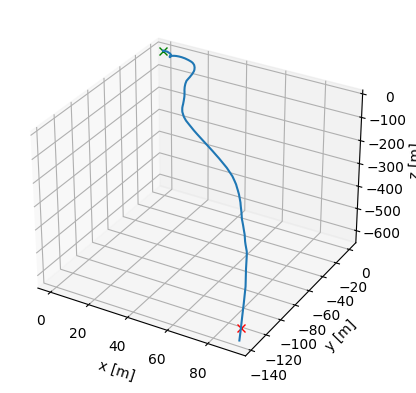

In [86]:
# plot it
fig = plt.figure()
ax = plt.axes(projection='3d')
xdata = vec_position[:, 0]
ydata = vec_position[:, 1]
zdata = vec_position[:, 2]

ax.plot(*start_pos, 'gx')
ax.plot(*end_pos, 'rx')
ax.plot(xdata, ydata, zdata)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
plt.show()